# MIE524 - Assignment 5
Please complete this notebook for Assignment 5.

## Imports

In [52]:
import pandas as pd
import numpy as np

## Q1 - Neural Collaborative Filtering
[[paper]](https://arxiv.org/pdf/1708.05031.pdf)

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Data
The MovieLens dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies.

In [75]:
data = pd.read_csv("q1-ratings.csv")

### Encode Data

In [76]:
# split train and validation before encoding
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()

In [77]:
train.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [78]:
val.head(3)

,userId,movieId,rating,timestamp
4,1,50,5.0,964982931
5,1,70,3.0,964982400
29,1,543,4.0,964981179


In [79]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continuous ids.
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [80]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids.
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [81]:
# encoding the train and validation data
df_train = encode_data(train)
df_val = encode_data(val, train)

## a) Evaluate model parameters for NCF-GMF

In [82]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users +1, emb_size)
        self.item_emb = nn.Embedding(num_items +1, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)

In [83]:
num_users = df_train.userId.max() #609
num_items = df_train.movieId.max() #8997
emb_size = 400

In [84]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()

    Train_Loss = []
    Val_Loss = []  # List to store validation losses

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Training data
        users = torch.LongTensor(df_train.userId.values)
        items = torch.LongTensor(df_train.movieId.values)
        ratings = torch.FloatTensor(df_train.rating.values)

        y_hat = model(users, items)
        loss = criterion(y_hat, ratings)

        loss.backward()
        optimizer.step()

        Train_Loss.append(loss.item())

        # Validation data evaluation
        model.eval()
        users_val = torch.LongTensor(df_val.userId.values)
        items_val = torch.LongTensor(df_val.movieId.values)
        ratings_val = torch.FloatTensor(df_val.rating.values)

        y_hat_val = model(users_val, items_val)
        val_loss = criterion(y_hat_val, ratings_val)
        Val_Loss.append(val_loss.item())

        # print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    print(f"Train Loss: {Train_Loss}")
    print(f"Val Loss: {Val_Loss}")

    return Train_Loss, Val_Loss


In [85]:
def plot_losses(train_losses, val_losses, emb_size, reg_strength, subplot_index):
    plt.subplot(3, 3, subplot_index)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Emb_size={emb_size}, Reg_strength={reg_strength}')
    plt.legend()



===================== Experiment 1 with emb_size=5 and reg_strength=0 =====================
Train Loss: [13.32348346710205, 13.302465438842773, 13.274651527404785, 13.240041732788086, 13.198561668395996, 13.150087356567383, 13.09447956085205, 13.031583786010742, 12.961233139038086, 12.883260726928711, 12.797505378723145, 12.703813552856445, 12.602033615112305, 12.49203109741211, 12.373685836791992, 12.246892929077148, 12.111566543579102, 11.967641830444336, 11.815074920654297, 11.653850555419922, 11.483976364135742, 11.305489540100098, 11.118457794189453, 10.922981262207031, 10.719192504882812, 10.507257461547852, 10.287381172180176, 10.059802055358887, 9.824799537658691, 9.582688331604004, 9.33382797241211, 9.078612327575684, 8.817477226257324, 8.550901412963867, 8.279397010803223, 8.003521919250488, 7.723867893218994, 7.441064357757568, 7.1557793617248535, 6.86870813369751, 6.5805816650390625, 6.292159080505371, 6.004218101501465, 5.717563629150391, 5.433012962341309, 5.151393890380

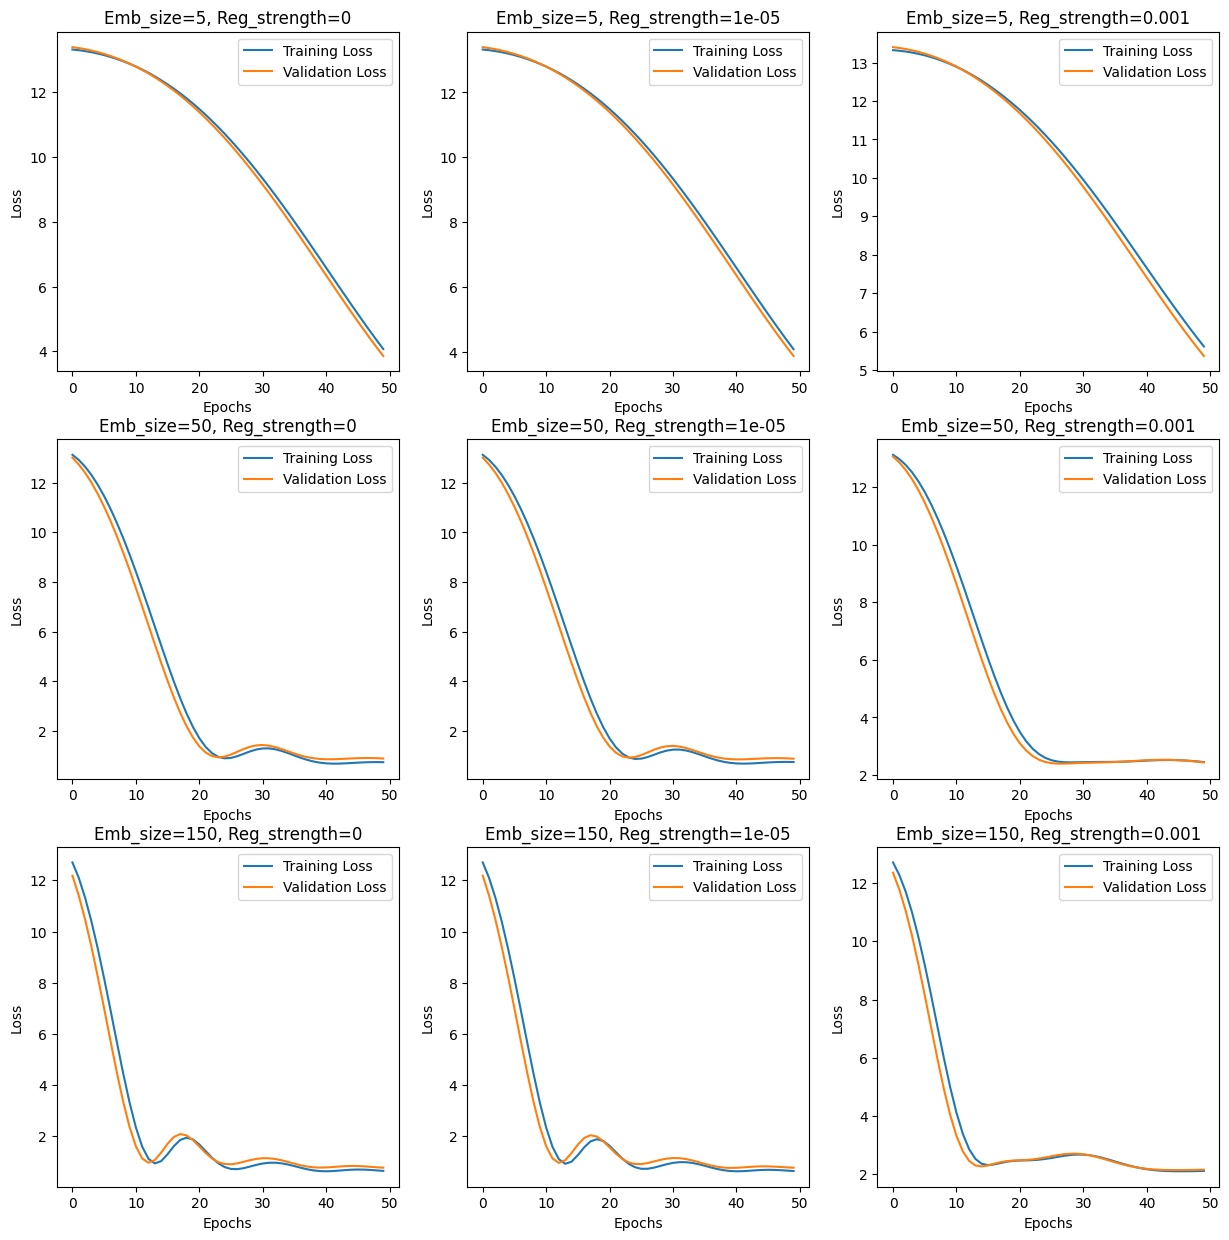

In [89]:
plt.figure(figsize=(15, 15))

emb_sizes = [5, 50, 150]
regs = [0, 1e-5, 1e-3]
experiment_num = 1

val_losses_dict={}

for i, emb_size in enumerate(emb_sizes):
    for j, reg_strength in enumerate(regs):
        print(f"\n===================== Experiment {experiment_num} with emb_size={emb_size} and reg_strength={reg_strength} =====================")

        # Creating and initializing the model for each experiment
        model = MF(num_users, num_items, emb_size=emb_size)

        # Training the model and getting losses
        train_losses_plt, val_loss_plt = train_epocs(model, epochs=50, lr=0.01, wd=reg_strength)

        # Store to print later
        val_losses_dict[(emb_size, reg_strength)] = val_loss_plt[-1]

        # Plotting losses
        plot_losses(train_losses_plt, val_loss_plt, emb_size, reg_strength, i * len(regs) + j + 1)


        experiment_num += 1
plt.show()

In [90]:
interested_emb_size = 50
interested_reg_strength = 0
print(f"emb: {interested_emb_size} + reg: {interested_reg_strength} => final val loss: {val_losses_dict[(interested_emb_size, interested_reg_strength)]}")

interested_emb_size = 150
interested_reg_strength = 1e-05
print(f"emb: {interested_emb_size} + reg: {interested_reg_strength} => final val loss: {val_losses_dict[(interested_emb_size, interested_reg_strength)]}")

emb: 50 + reg: 0 => final val loss: 0.880730152130127
emb: 150 + reg: 1e-05 => final val loss: 0.7725489139556885


### Compare the impact of changing the embedding size and the role of regularization on NCF-GMF. <br> Evaluate the performance of at least two different configurations using MSE.

Reading the chart from left to right demonstrates varying regularization strengths and their effects, while top-to-bottom analysis showcases diverse embedding sizes and their impacts.

Increasing the embedding size allows it to capture more intricate relationships which lead to a faster convergence (i.e., train loss lower than validation loss). But this accerlation also imposes higher chance for the model to overfit. In contrast, the role of regularization is to help prevent overfitting by penalizing large weights or complex models. Therefore you see that higher regualization strength delays the the convergence.

See the model with Embedding Size of 50 and Regularization strength of 0. At around epoch 22, it converges. Then, See the model with Embedding Size of 150 and Regularization strenght of 1e-05. The embedding size has tripled but the regularization strenght is still fairly low. Therefore, the convergence happened quicker at around epoch 11. As a result, it's final MSE loss for validation set was lower with 0.77 as compared to 0.88 for the other model.

## b) NCF-MLP Model

### Train the model on the provided train set using the Adam optimizer and the MSE loss function for 10 epochs. Report the loss on the validation set of each epoch.

<img src=https://miro.medium.com/v2/resize:fit:1400/format:webp/1*aP-Mx266ExwoWZPSdHtYpA.png width="600">


In [64]:
class my_NCF_MLP(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10):
        super(my_NCF_MLP, self).__init__()
        self.user_emb = nn.Embedding(num_users +1 , emb_size)
        self.item_emb = nn.Embedding(num_items +1, emb_size)
        self.fc_layers = nn.Sequential(
            nn.Linear(emb_size * 2, hidden_size), # user-item embeddings concatenated
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, u, v):
        # Get embeddings for users and items
        user_embedding = self.user_emb(u)
        item_embedding = self.item_emb(v)

        # Concatenate user and item embeddings
        concatenated = torch.cat((user_embedding, item_embedding), dim=1)

        # Pass through fully connected layers
        output = self.fc_layers(concatenated)
        return output.squeeze()


 ===================== Experimenting with emb_size=50 and reg_strength=0.01 =====================
Train Loss: [14.385801315307617, 13.899757385253906, 13.425931930541992, 12.964649200439453, 12.515816688537598, 12.078217506408691, 11.649086952209473, 11.225138664245605, 10.803650856018066, 10.382963180541992, 9.962502479553223, 9.543390274047852, 9.127298355102539, 8.716484069824219, 8.313536643981934, 7.921288013458252, 7.542373180389404, 7.179539203643799, 6.835079193115234, 6.510807037353516, 6.20791482925415, 5.926732063293457, 5.666635036468506, 5.426156520843506, 5.20309591293335, 4.994730472564697, 4.798325538635254, 4.611401081085205, 4.431883811950684, 4.258567810058594, 4.090878486633301, 3.928793430328369, 3.7727699279785156, 3.6236913204193115, 3.482274293899536, 3.34916090965271, 3.225017786026001, 3.1100800037384033, 3.003983736038208, 2.9063048362731934, 2.816444158554077, 2.7336857318878174, 2.6573848724365234, 2.5867040157318115, 2.5209665298461914, 2.459608316421509,

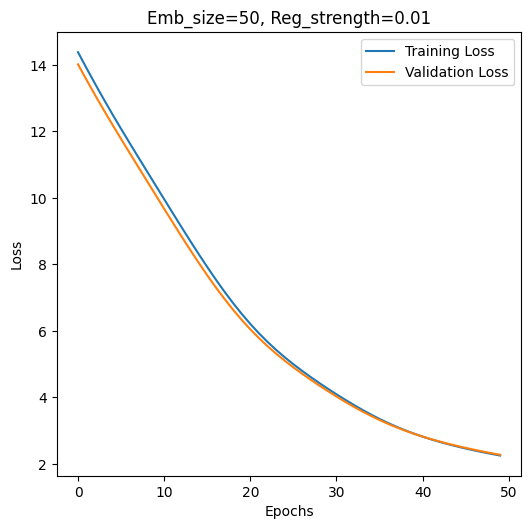


Final Validation Loss: 2.2700963020324707


In [69]:
plt.figure(figsize=(15, 15))

# Experiment
emb_sizes = [50]
regs = [0.01]


for i, emb_size in enumerate(emb_sizes):
    for j, reg_strength in enumerate(regs):
        print(f"\n ===================== Experimenting with emb_size={emb_size} and reg_strength={reg_strength} =====================")

        # Creating and initializing the model for each experiment
        model = my_NCF_MLP(num_users, num_items, emb_size=emb_size, hidden_size=5)

        # Training the model and getting losses
        train_losses_plt, val_losses_plt = train_epocs(model, epochs=50, lr=0.01, wd=reg_strength)

        # Plotting losses
        plot_losses(train_losses_plt, val_losses_plt, emb_size, reg_strength, i * len(regs) + j + 1)

plt.tight_layout()
plt.show()

print("\nFinal Validation Loss:", val_losses_plt[-1])

### c) Evaluate model parameters for NCF-MLP. <br> Evaluate the performance of at least two different configurations using MSE.


 Experimenting with emb_size=5 and reg_strength=0
Train Loss: [9.398340225219727, 9.131155967712402, 8.854220390319824, 8.567893028259277, 8.272724151611328, 7.96928596496582, 7.65818452835083, 7.340104103088379, 7.015992164611816, 6.686866283416748, 6.35394287109375, 6.018661022186279, 5.682705402374268, 5.347909450531006, 5.016440391540527, 4.690781593322754, 4.373562812805176, 4.0675835609436035, 3.775800943374634, 3.501265525817871, 3.246936321258545, 3.015432119369507, 2.8088173866271973, 2.628396987915039, 2.474353551864624, 2.345665693283081, 2.239967107772827, 2.153702974319458, 2.0825035572052, 2.021620035171509, 1.9665788412094116, 1.9137343168258667, 1.8606189489364624, 1.8059827089309692, 1.7497059106826782, 1.6926034688949585, 1.6359763145446777, 1.5813415050506592, 1.5302157402038574, 1.4838333129882812, 1.442935585975647, 1.4078125953674316, 1.3783844709396362, 1.3541542291641235, 1.334343671798706, 1.3180691003799438, 1.304336667060852, 1.2922106981277466, 1.2808631658

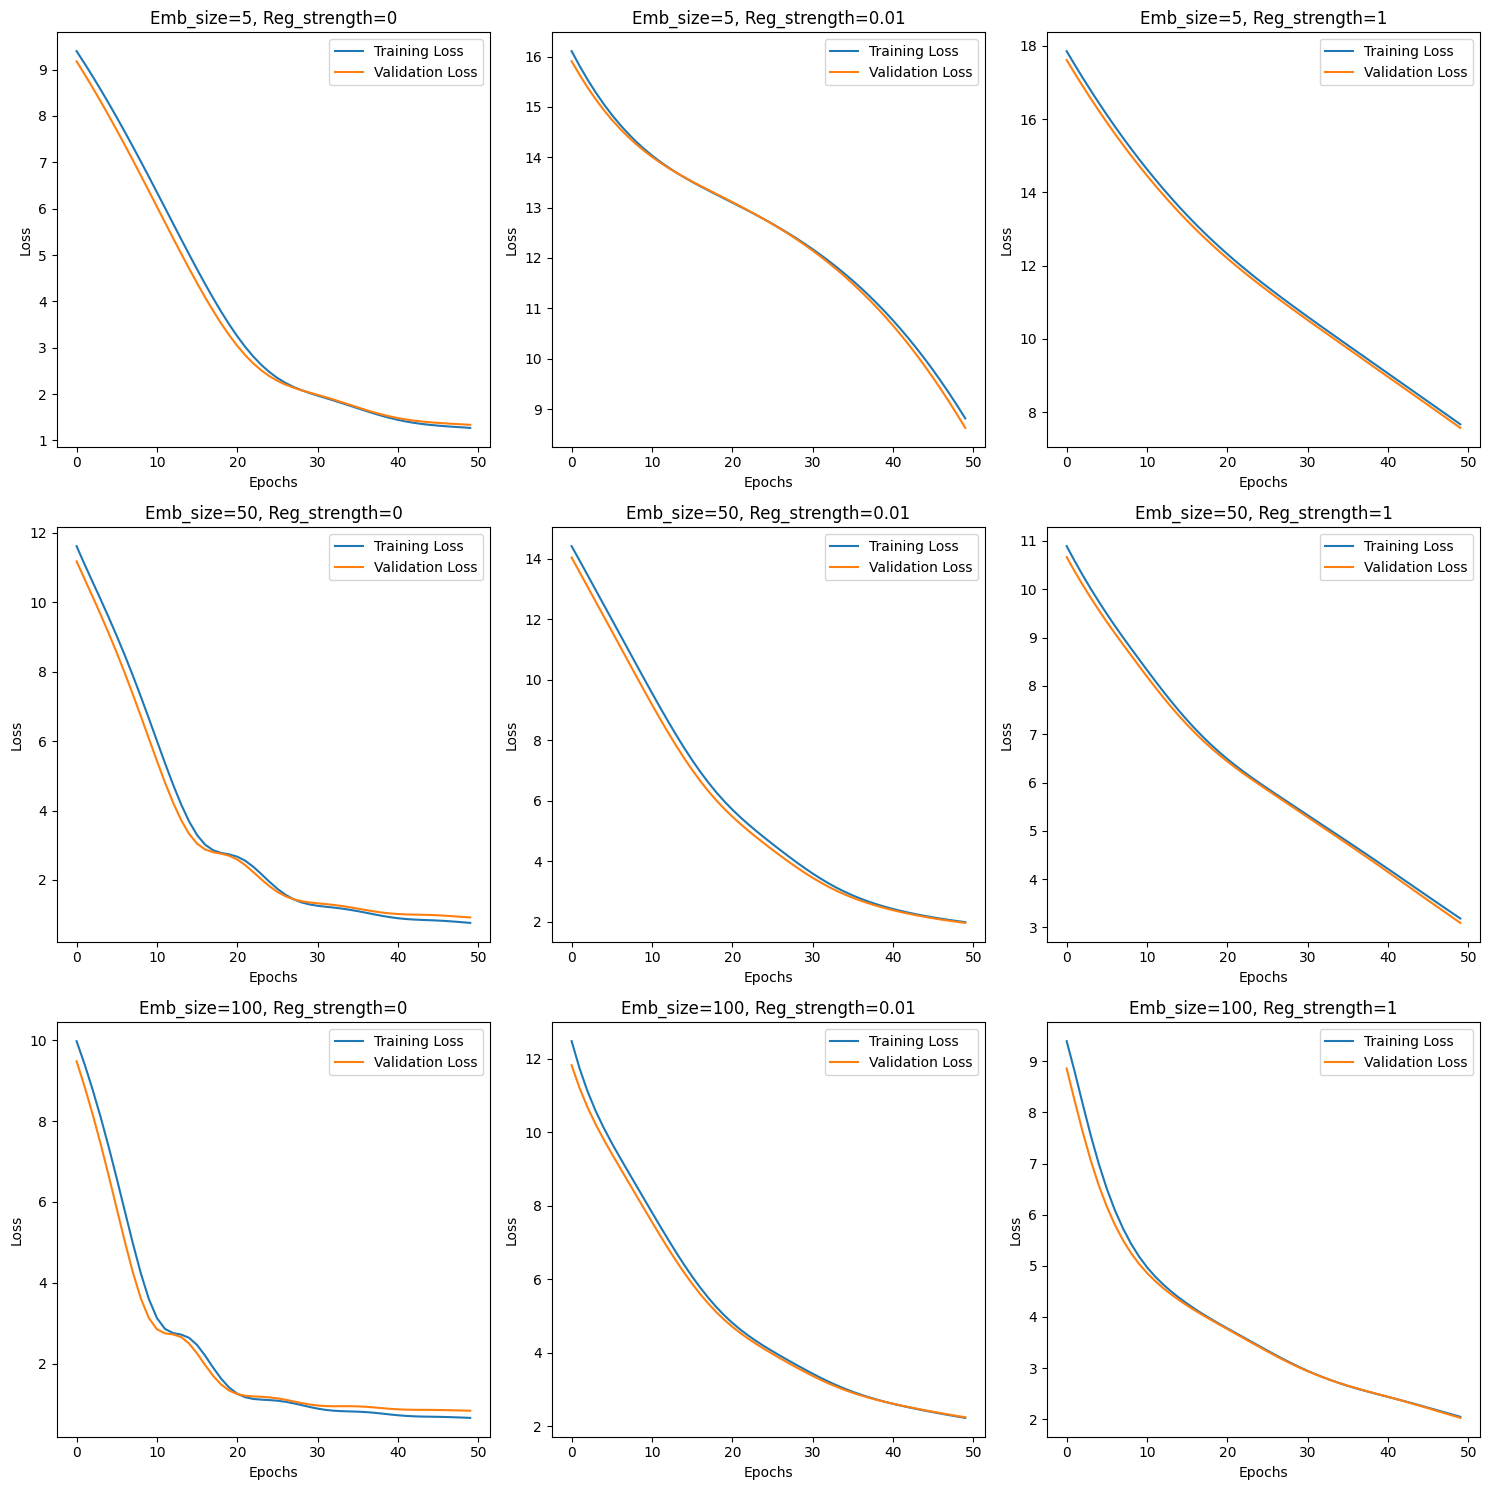

In [71]:
plt.figure(figsize=(15, 15))
experiment_num = 1

# Experiment
emb_sizes = [5, 50, 100]
regs = [0, 0.01, 1]
experiment_num = 1

val_losses_dict = {}

for i, emb_size in enumerate(emb_sizes):
    for j, reg_strength in enumerate(regs):
        print(f"\n Experimenting with emb_size={emb_size} and reg_strength={reg_strength}")

        # Model for each experiment
        model = my_NCF_MLP(num_users, num_items, emb_size=emb_size, hidden_size=5)

        # Training the model and getting losses
        train_losses_plt, val_losses_plt = train_epocs(model, epochs=50, lr=0.01, wd=reg_strength)

        # Store to print later
        val_losses_dict[(emb_size, reg_strength)] = val_losses_plt[-1]

        # Plotting losses
        plot_losses(train_losses_plt, val_losses_plt, emb_size, reg_strength, i * len(regs) + j + 1)

        experiment_num += 1

print("\n +++++++++++++++ PLOT ++++++++++++++++ ")
plt.tight_layout()
plt.show()

In [74]:
interested_emb_size = 100
interested_reg_strength = 0
print(f"emb: {interested_emb_size} + reg: {interested_reg_strength} => final val loss: {val_losses_dict[(interested_emb_size, interested_reg_strength)]}")

interested_emb_size = 5
interested_reg_strength = 1
print(f"emb: {interested_emb_size} + reg: {interested_reg_strength} => final val loss: {val_losses_dict[(interested_emb_size, interested_reg_strength)]}")

emb: 100 + reg: 0 => final val loss: 0.831413745880127
emb: 5 + reg: 1 => final val loss: 7.573823928833008


#### Evaluate the performance of at least two different configurations using MSE.

See the model with embedding size of 100 and Regularization strenght of 0 compared to the model that with an embedding size of 5 and reugluralization strength of 1. With high embedding size and low regularizaiton stregnth, it quickly converges. Therefore it has a very low final validation loss of 0.84. On the other hand, for the case of the second model where it has low embedding size but strong regularization strength, the loss is going down in a linear manner and is converging very slow. Therefore, it still has a very high final loss of 7.57.

Note, it seems like most of the models are still training very well - this is due to low epochs number. With increase of epochs more rigorous analysis can be done.

### d) Compare your best NCF-GMF and NCF-MLP

In [91]:
# Function to train NCF-GMF model
def train_ncf_gmf(num_users, num_items, emb_size, reg_strength):
    model = MF(num_users, num_items, emb_size=emb_size)
    train_losses, val_losses = train_epocs(model, epochs=50, lr=0.01, wd=reg_strength)
    return train_losses, val_losses

# Function to train NCF-MLP model
def train_ncf_mlp(num_users, num_items, emb_size, hidden_size, reg_strength):
    model = my_NCF_MLP(num_users, num_items, emb_size=emb_size, hidden_size=hidden_size)
    train_losses, val_losses = train_epocs(model, epochs=50, lr=0.01, wd=reg_strength)
    return train_losses, val_losses



===================== Experiment for emb_size=5, reg_strength=0 ========================

Training NCF-GMF...
Train Loss: [13.322693824768066, 13.301363945007324, 13.273235321044922, 13.238300323486328, 13.196488380432129, 13.147683143615723, 13.0917387008667, 13.028502464294434, 12.957810401916504, 12.879498481750488, 12.793405532836914, 12.699374198913574, 12.597260475158691, 12.486928939819336, 12.36826229095459, 12.2411527633667, 12.105518341064453, 11.961291313171387, 11.80843734741211, 11.646932601928711, 11.476789474487305, 11.298049926757812, 11.11077880859375, 10.915078163146973, 10.711078643798828, 10.498952865600586, 10.278901100158691, 10.051166534423828, 9.81602668762207, 9.57380199432373, 9.324845314025879, 9.069557189941406, 8.808372497558594, 8.541769981384277, 8.270263671875, 7.994408130645752, 7.7148003578186035, 7.432067394256592, 7.146875381469727, 6.859923839569092, 6.571942329406738, 6.283685684204102, 5.995937824249268, 5.709498405456543, 5.425185680389404, 5.14

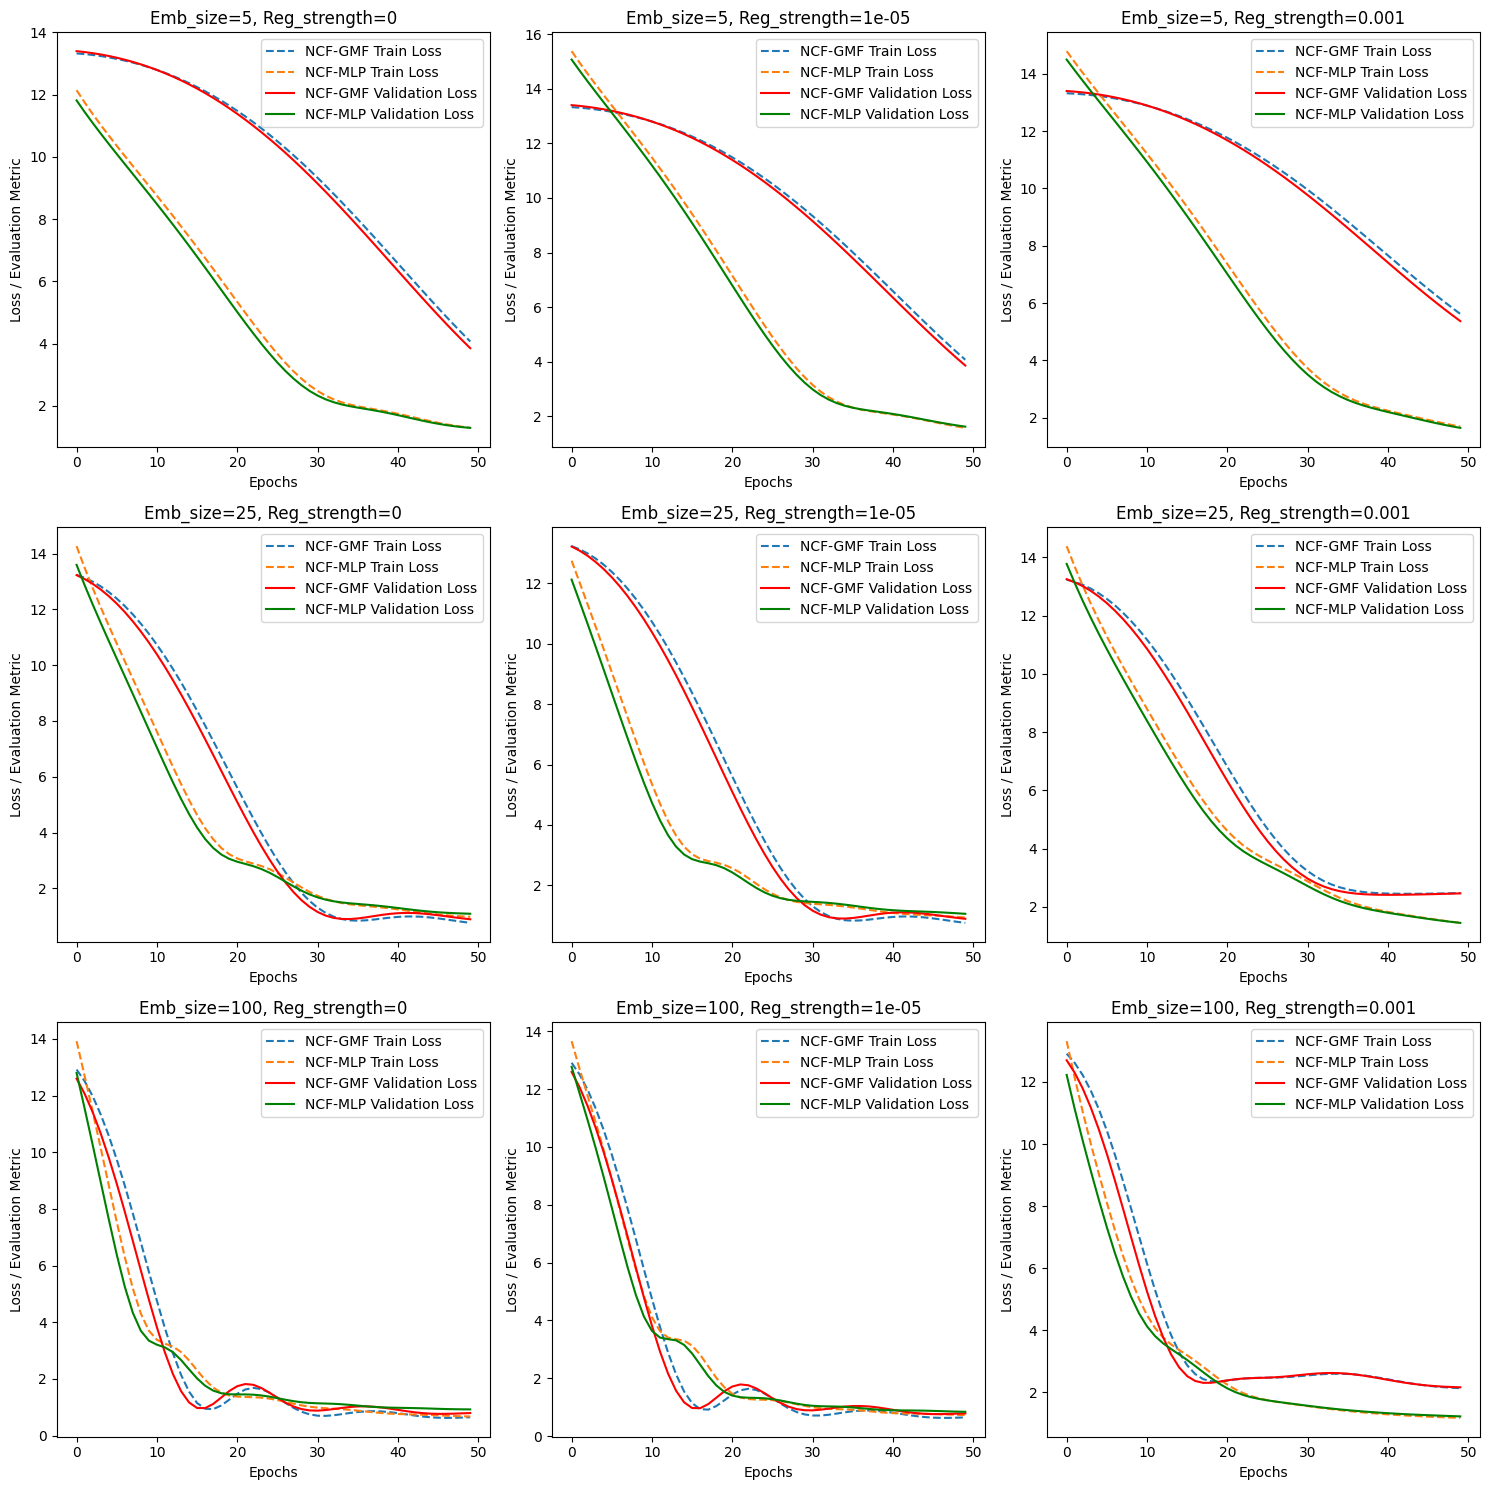

valid_gmf_results [{'model': 'NCF-GMF', 'emb_size': 5, 'reg_strength': 0, 'evaluation_metric': [13.39503002166748, 13.366774559020996, 13.331679344177246, 13.289666175842285, 13.240620613098145, 13.184398651123047, 13.120844841003418, 13.04979133605957, 12.971076965332031, 12.884537696838379, 12.790016174316406, 12.687363624572754, 12.576447486877441, 12.457144737243652, 12.329351425170898, 12.19297981262207, 12.047966957092285, 11.894268989562988, 11.731868743896484, 11.56077766418457, 11.38102912902832, 11.192696571350098, 10.995875358581543, 10.790700912475586, 10.577340126037598, 10.355999946594238, 10.126920700073242, 9.89038372039795, 9.646707534790039, 9.396254539489746, 9.139421463012695, 8.876653671264648, 8.608427047729492, 8.335265159606934, 8.057727813720703, 7.7764129638671875, 7.491957187652588, 7.20503044128418, 6.916339874267578, 6.626620769500732, 6.3366379737854, 6.047181606292725, 5.759063243865967, 5.473111152648926, 5.190164566040039, 4.911070823669434, 4.636674880

In [96]:
# Parameters for the experiments
emb_sizes = [5, 25, 100]
regs = [0, 1e-5, 1e-3]
experiment_results = []

# Create a 3x3 grid of subplots for 9 plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

results_test = []
# Experiment for NCF-GMF and NCF-MLP with the same parameters plotted on the same graph
for i, emb_size in enumerate(emb_sizes):
    for j, reg_strength in enumerate(regs):
        print(f"\n===================== Experiment for emb_size={emb_size}, reg_strength={reg_strength} ========================")

        # Train NCF-GMF
        print("\nTraining NCF-GMF...")
        train_losses_gmf, val_losses_gmf = train_ncf_gmf(num_users, num_items, emb_size, reg_strength)
        # print("GMF VAL LOSS:", val_losses_gmf)

        # Train NCF-MLP
        print("\nTraining NCF-MLP...")
        train_losses_mlp, val_losses_mlp = train_ncf_mlp(num_users, num_items, emb_size, 10, reg_strength)
        # print("MLP VAL LOSS:", val_losses_mlp)


        # Store experiment results
        experiment_results.append({
            'model': 'NCF-GMF',
            'emb_size': emb_size,
            'reg_strength': reg_strength,
            'evaluation_metric': val_losses_gmf
        })

        experiment_results.append({
            'model': 'NCF-MLP',
            'emb_size': emb_size,
            'reg_strength': reg_strength,
            'evaluation_metric': val_losses_mlp
        })

        #results_test.append([test_losses_gmf, test_losses_mlp])

        # Plot training losses for NCF-GMF and NCF-MLP on subplots
        axs[i, j].plot(train_losses_gmf, label='NCF-GMF Train Loss', linestyle='--')
        axs[i, j].plot(train_losses_mlp, label='NCF-MLP Train Loss', linestyle='--')

        # Plot horizontal lines for evaluation metrics
        axs[i, j].plot(val_losses_gmf, color='red', linestyle='-', label='NCF-GMF Validation Loss')
        axs[i, j].plot(val_losses_mlp, color='green', linestyle='-', label='NCF-MLP Validation Loss')

        axs[i, j].set_title(f"Emb_size={emb_size}, Reg_strength={reg_strength}")
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].set_ylabel('Loss / Evaluation Metric')
        axs[i, j].legend()

print("\n +++++++++++++++ PLOT ++++++++++++++++ ")
plt.tight_layout()
plt.show()


valid_gmf_results = [result for result in experiment_results if result['model'] == 'NCF-GMF' and result['evaluation_metric'] is not None]
valid_mlp_results = [result for result in experiment_results if result['model'] == 'NCF-MLP' and result['evaluation_metric'] is not None]

print("valid_gmf_results", valid_gmf_results)

if valid_gmf_results:
    best_gmf_model_result = min(valid_gmf_results, key=lambda x: min(x['evaluation_metric']))
    print("\nBest NCF-GMF Model:")
    print(f"Emb Size: {best_gmf_model_result['emb_size']}")
    print(f"Regularization Strength: {best_gmf_model_result['reg_strength']}")
    print(f"Evaluation Metric: {min(best_gmf_model_result['evaluation_metric'])}")

if valid_mlp_results:
    best_mlp_model_result = min(valid_mlp_results, key=lambda x: min(x['evaluation_metric']))
    print("\nBest NCF-MLP Model:")
    print(f"Emb Size: {best_mlp_model_result['emb_size']}")
    print(f"Regularization Strength: {best_mlp_model_result['reg_strength']}")
    print(f"Evaluation Metric: {min(best_mlp_model_result['evaluation_metric'])}")


### Based on your experiments, compare your best NCF-GMF and NCF-MLP. Comment on the results.

Best NCF-GMF Model:
*   Emb Size: 100
*   Regularization Strength: 1e-05
*   Last Loss: 0.76

Best NCF-MLP Model:
*   Emb Size: 100
*   Regularization Strength: 0
*   Last Loss: 0.84

The hyperparameters for the best performance for the two models were different. Though it seems to agree that the embedding size of 100 is the best. The two have similar final loss values but with 50 epochs NCF-GMF seems to perform better than NCF-MLP. Note, this result may change with increase in epochs.

Qualitatively assessing (not only the best model of each) but including all the different models with the graph, MLP seems to be more stable and perform better. Especially when there are smaller embedding sizes, MLP outperforms GMF.

### e) Change ratings to 1 or 0 such that any rating greater or equal to 3 is mapped to 1 and any rating less than 3 is mapped to 0. Compare your best NCF-GMF and NCF-MLP on this new dataset. What do you observe differently? Would you change anything about your implementation to conform with this new dataset?

In [97]:
# Change ratings to 1 or 0
train['rating_binary'] = train['rating'].apply(lambda x: 1 if x >= 3 else 0)
val['rating_binary'] = val['rating'].apply(lambda x: 1 if x >= 3 else 0)


# Modified ratings
df_train = encode_data(train)
df_val = encode_data(val, train)

num_users = df_train.userId.max() #609
num_items = df_train.movieId.max() #8997


In [98]:
class MF_BC(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF_BC, self).__init__()
        self.user_emb = nn.Embedding(num_users + 1, emb_size)
        self.item_emb = nn.Embedding(num_items + 1, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, users, items):
        user_embedding = self.user_emb(users)
        item_embedding = self.item_emb(items)
        prediction = (user_embedding*item_embedding).sum(1)
        output = torch.sigmoid(prediction)
        return output


class my_NCF_MLP_BC(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10):
        super(my_NCF_MLP_BC, self).__init__()
        self.user_emb = nn.Embedding(num_users + 1, emb_size)
        self.item_emb = nn.Embedding(num_items + 1, emb_size)
        self.fc_layers = nn.Sequential(
            nn.Linear(emb_size * 2, hidden_size),  # user-item embeddings concatenated
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, u, v):
        user_embedding = self.user_emb(u)
        item_embedding = self.item_emb(v)
        concatenated = torch.cat((user_embedding, item_embedding), dim=1)
        output = self.fc_layers(concatenated)
        return torch.sigmoid(output.squeeze())

def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.BCELoss()

    Train_Loss = []
    Val_Loss = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        users = torch.LongTensor(df_train.userId.values)
        items = torch.LongTensor(df_train.movieId.values)
        ratings = torch.FloatTensor(df_train.rating_binary.values)

        y_hat = model(users, items)
        loss = criterion(y_hat, ratings)

        loss.backward()
        optimizer.step()

        Train_Loss.append(loss.item())

        model.eval()
        users_val = torch.LongTensor(df_val.userId.values)
        items_val = torch.LongTensor(df_val.movieId.values)
        ratings_val = torch.FloatTensor(df_val.rating_binary.values)

        y_hat_val = model(users_val, items_val)
        val_loss = criterion(y_hat_val, ratings_val)
        Val_Loss.append(val_loss.item())

    print(f"Train Loss: {Train_Loss}")
    print(f"Val Loss: {Val_Loss}")

    return Train_Loss, Val_Loss


In [99]:
# Function to train NCF-GMF model
def train_ncf_gmf_bc(num_users, num_items, emb_size, reg_strength):
    model = MF_BC(num_users, num_items, emb_size=emb_size)
    train_losses, val_losses = train_epocs(model, epochs=100, lr=0.01, wd=reg_strength)
    return train_losses, val_losses

# Function to train NCF-MLP model
def train_ncf_mlp_bc(num_users, num_items, emb_size, hidden_size, reg_strength):
    model = my_NCF_MLP_BC(num_users, num_items, emb_size=emb_size, hidden_size=hidden_size)
    train_losses, val_losses = train_epocs(model, epochs=100, lr=0.01, wd=reg_strength)
    return train_losses, val_losses


===================== Experiment for emb_size=5, reg_strength=0 ========================

Training NCF-GMF...
Train Loss: [0.6921750903129578, 0.6911848187446594, 0.6898775100708008, 0.6882466077804565, 0.6862874627113342, 0.6839954257011414, 0.6813654899597168, 0.6783929467201233, 0.6750733852386475, 0.6714031100273132, 0.6673795580863953, 0.6630010604858398, 0.65826815366745, 0.6531819701194763, 0.6477464437484741, 0.6419669389724731, 0.6358510255813599, 0.6294087171554565, 0.6226519346237183, 0.6155955195426941, 0.608256459236145, 0.6006542444229126, 0.5928105711936951, 0.5847494602203369, 0.5764971971511841, 0.5680819153785706, 0.559533953666687, 0.5508848428726196, 0.5421680808067322, 0.5334176421165466, 0.5246686339378357, 0.5159559845924377, 0.5073144435882568, 0.49877768754959106, 0.4903782308101654, 0.48214665055274963, 0.4741111397743225, 0.4662971496582031, 0.45872703194618225, 0.45141980051994324, 0.44439083337783813, 0.43765223026275635, 0.43121233582496643, 0.42507621645

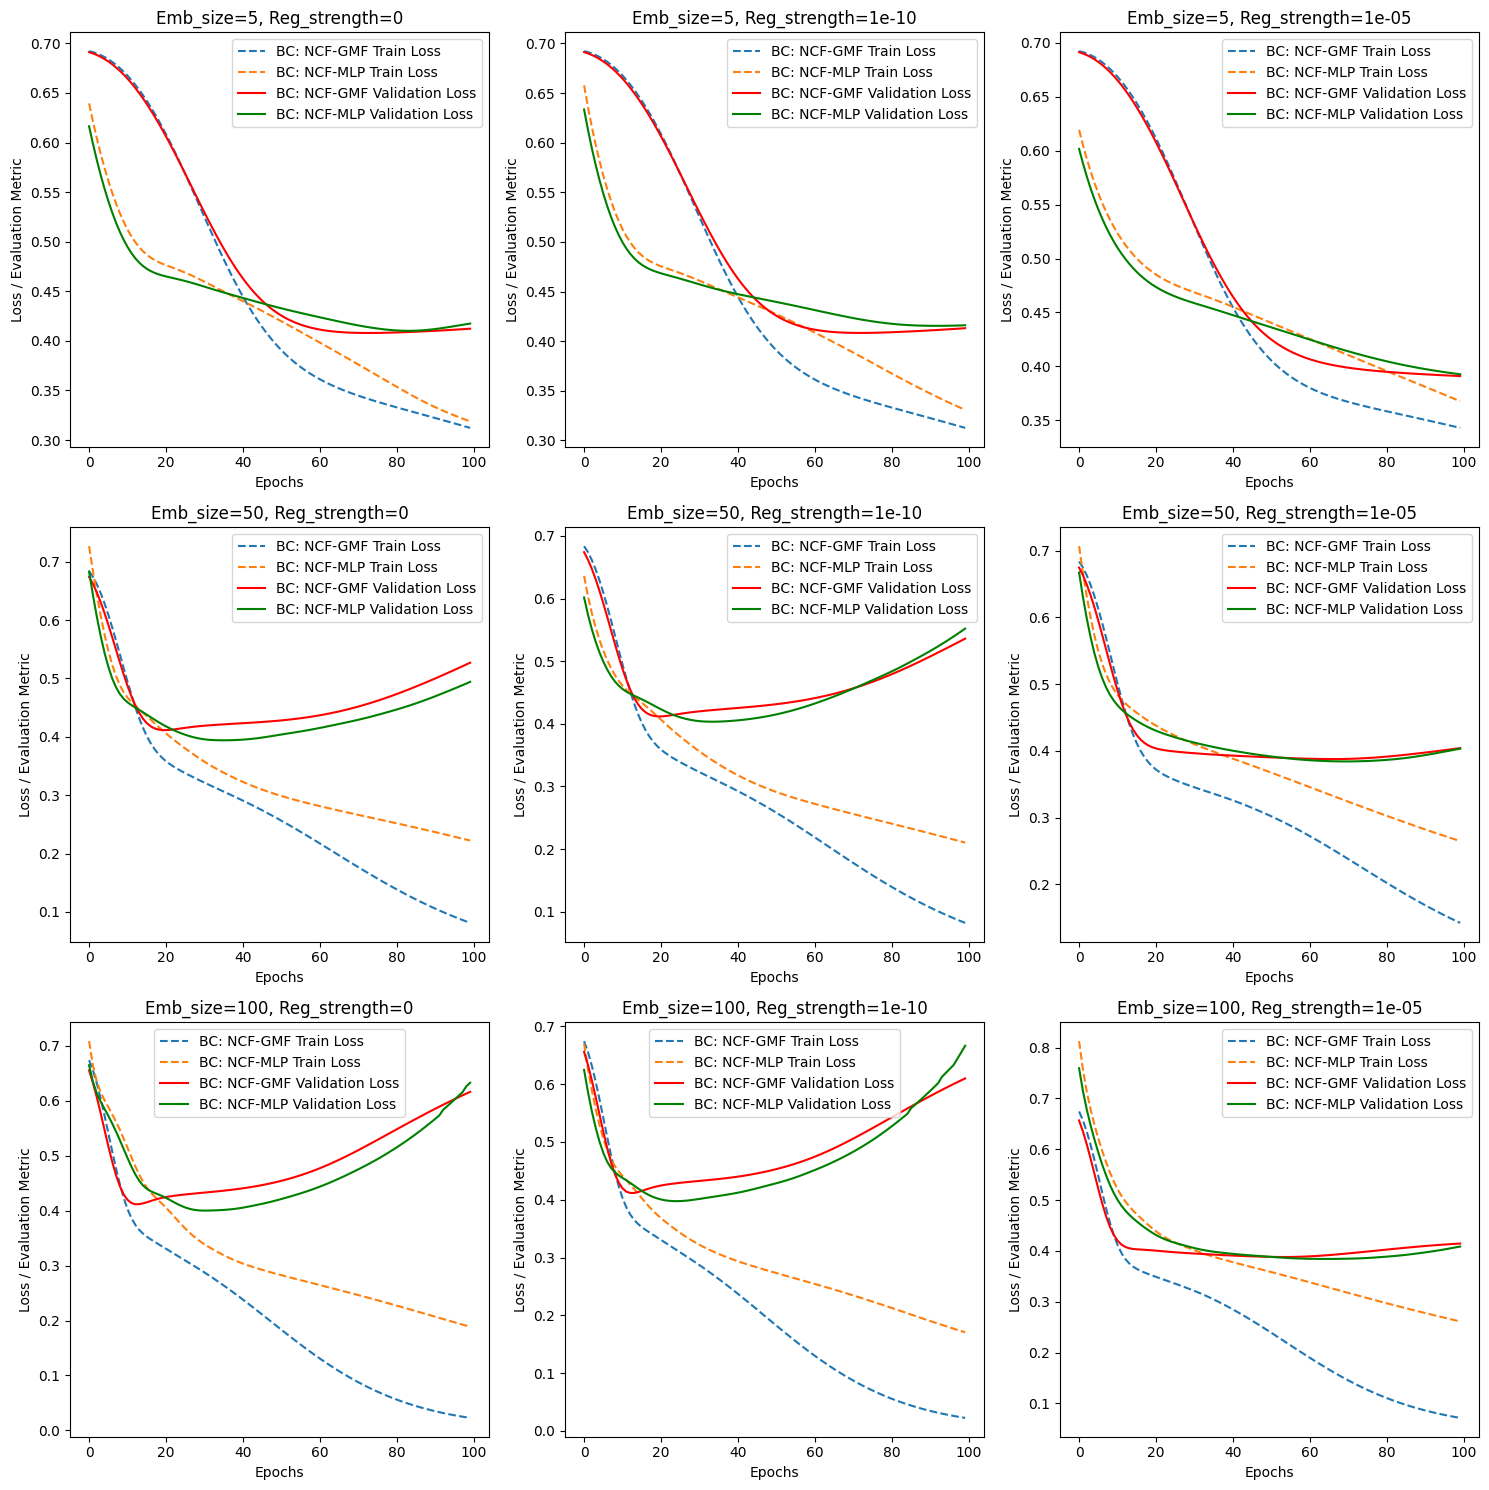


Best NCF-GMF Model:
Emb Size: 100
Regularization Strength: 1e-05
Evaluation Metric: 0.40050041675567627

Best NCF-MLP Model:
Emb Size: 100
Regularization Strength: 1e-10
Last Loss with Early Stopping: 0.4004451632499695


In [100]:
# Parameters for the experiments
emb_sizes = [5, 50, 100]
regs = [0, 1e-10, 1e-05]
experiment_results = []

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

results_test = []

for i, emb_size in enumerate(emb_sizes):
    for j, reg_strength in enumerate(regs):
        print(f"\n===================== Experiment for emb_size={emb_size}, reg_strength={reg_strength} ========================")

        # Train NCF-GMF
        print("\nTraining NCF-GMF...")
        train_losses_gmf, val_losses_gmf = train_ncf_gmf_bc(num_users, num_items, emb_size, reg_strength)

        # Train NCF-MLP
        print("\nTraining NCF-MLP...")
        train_losses_mlp, val_losses_mlp = train_ncf_mlp_bc(num_users, num_items, emb_size, 10, reg_strength)

        # Store experiment results
        experiment_results.append({
            'model': 'NCF-GMF',
            'emb_size': emb_size,
            'reg_strength': reg_strength,
            'evaluation_metric': val_losses_gmf
        })

        experiment_results.append({
            'model': 'NCF-MLP',
            'emb_size': emb_size,
            'reg_strength': reg_strength,
            'evaluation_metric': val_losses_mlp
        })


        # Plot training losses for NCF-GMF and NCF-MLP on subplots
        axs[i, j].plot(train_losses_gmf, label='BC: NCF-GMF Train Loss', linestyle='--')
        axs[i, j].plot(train_losses_mlp, label='BC: NCF-MLP Train Loss', linestyle='--')

        # Plot horizontal lines for evaluation metrics
        axs[i, j].plot(val_losses_gmf, color='red', linestyle='-', label='BC: NCF-GMF Validation Loss')
        axs[i, j].plot(val_losses_mlp, color='green', linestyle='-', label='BC: NCF-MLP Validation Loss')

        axs[i, j].set_title(f"Emb_size={emb_size}, Reg_strength={reg_strength}")
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].set_ylabel('Loss / Evaluation Metric')
        axs[i, j].legend()

print("++++++++++++++ PLOT +++++++++++++")
plt.tight_layout()
plt.show()


valid_gmf_results = [result for result in experiment_results if result['model'] == 'NCF-GMF' and result['evaluation_metric'] is not None]
valid_mlp_results = [result for result in experiment_results if result['model'] == 'NCF-MLP' and result['evaluation_metric'] is not None]

if valid_gmf_results:
    best_gmf_model_result = min(valid_gmf_results, key=lambda x: min(x['evaluation_metric'][:20])) # looking up till epoch 15
    print("\nBest NCF-GMF Model:")
    print(f"Emb Size: {best_gmf_model_result['emb_size']}")
    print(f"Regularization Strength: {best_gmf_model_result['reg_strength']}")
    print(f"Evaluation Metric: {best_gmf_model_result['evaluation_metric'][20]}")
else:
    print("No valid NCF-GMF results found.")

if valid_mlp_results:
    best_mlp_model_result = min(valid_mlp_results, key=lambda x: min(x['evaluation_metric'][:20])) # works like the earlystopping
    print("\nBest NCF-MLP Model:")
    print(f"Emb Size: {best_mlp_model_result['emb_size']}")
    print(f"Regularization Strength: {best_mlp_model_result['reg_strength']}")
    print(f"Last Loss with Early Stopping: {best_mlp_model_result['evaluation_metric'][20]}")
else:
    print("No valid NCF-MLP results found.")


### Compare your best NCF-GMF and NCF-MLP on this new dataset. What do you observe differently? Would you change anything about your implementation to conform with this new dataset?

When comparing the performances on this new dataset, I observed rapid overfitting. I believe this is mainly due to the task's simplicity—binary classification. Another notable observation is that this time, albeit by a small margin, the MLP model outperformed the GMF model, achieving an lower MSEloss of 0.4004 compared to 0.4005 for GMF. But even qualitatively, assessing the graphs, it seems like MLP does perform better than the GMP.

To adapt to the task's binary classification nature, I made necessary adjustments in my implementation. I've modified my implementation to add sigmoid to the output layer so it maps the output value to between 0 and 1. I've also modified the criterion to BCELoss to better suit this objective.

## Q2 - Zero-Shot Text Classification
https://huggingface.co/tasks/zero-shot-classification

In [101]:
!pip install transformers

In [102]:
from transformers import pipeline

### Data

In [103]:
import pandas as pd
import numpy as np

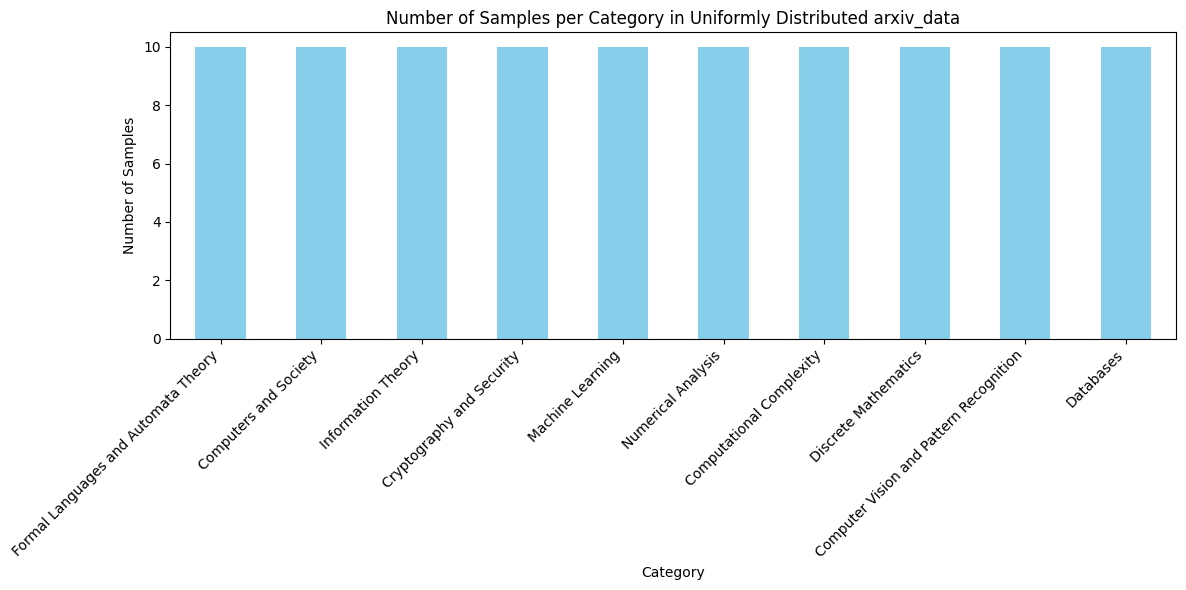

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import random


arxiv_data_original = pd.read_csv('q2-arxiv-metadata-oai-snapshot-small.csv', index_col=0)
grouped = arxiv_data_original.groupby('first_category_english') # Group the data by categories

# Randomly select 10 categories
random_categories = random.sample(list(grouped.groups.keys()), 10)

sampled_data = []

# Target number of samples per category
target_samples = 100 // len(random_categories)  # Divide samples uniformly across selected categories

# Iterate through each selected category and sample uniformly
for category in random_categories:
    group = grouped.get_group(category)

    if len(group) >= target_samples:
        samples = group.sample(n=target_samples, replace=True)
    else:
        samples = group.sample(n=target_samples, replace=True)
    sampled_data.append(samples)


arxiv_data = pd.concat(sampled_data)
arxiv_data = arxiv_data.sample(frac=1).reset_index(drop=True)

# Number of samples in each selected category
category_counts_uniform = arxiv_data['first_category_english'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(12, 6))
category_counts_uniform.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Category in Uniformly Distributed arxiv_data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

arxiv_candidate_labels = arxiv_data.first_category_english.unique()


### a) Predict the category (first category english) of each paper using the title of the paper and compute the accuracy and F1 scores.

In [7]:
# Model 1
from transformers import pipeline
pipe = pipeline(model="facebook/bart-large-mnli")

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    print("title:", row['title'])
    print("true_label:", row['first_category_english'])

    true_label = row['first_category_english']
    result = pipe(f"{row['title']}", candidate_labels=arxiv_candidate_labels)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)

    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Baseline: facebook/bart-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)


==================Iteration:1==================
title: Minimisation in Logical Form
true_label: Formal Languages and Automata Theory
predicted_label: Cryptography and Security
==================Iteration:2==================
title: Response to Office of the Privacy Commissioner of Canada Consultation
  Proposals pertaining to amendments to PIPEDA relative to Artificial
  Intelligence
true_label: Computers and Society
predicted_label: Computers and Society
==================Iteration:3==================
title: Prioritized Multi-stream Traffic in Uplink IoT Networks: Spatially
  Interacting Vacation Queues
true_label: Information Theory
predicted_label: Computational Complexity
==================Iteration:4==================
title: Why Older Adults (Don't) Use Password Managers
true_label: Cryptography and Security
predicted_label: Cryptography and Security
==================Iteration:5==================
title: Canonicity in GFG and Transition-Based Automata
true_label: Formal Languages a

### b) For which categories does the Zero-Shot Learning framework perform poorly? What are some possible reasons and what might you try to improve the performance?

The Zero-Shot Learning framework exhibited lower performance in categories such as 'computer vision and pattern recognition', 'databases', and 'information theory'. Notice that 'databases' and 'information theory' represent broader domains encompassing diverse topics, unlike 'cybersecurity', which stands as a more specific and well-defined niche within these extensive categories. Additionally, 'computer vision' is a subset of machine learning, and 'machine learning' being one of the available label options, this class performs poorly.

To enhance the model's performance in these complex categories, incorporating richer contextual information beyond the titles can be helpful. Additional contextual cues or domain-specific features let model to better understand the nuanced differences. This strategy will allow the model to have a more comprehensive understanding of the underlying distinctions, thereby making more accurate inferences across diverse and hierarchical classes.


### c) Evaluate different language models

In [9]:
# MODEL2
pipe = pipeline("zero-shot-classification", model="roberta-large-mnli")

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    print("title:", row['title'])
    print("true_label:", row['first_category_english'])
    true_label = row['first_category_english']
    result = pipe(f"{row['title']}", candidate_labels=arxiv_candidate_labels)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: roberta-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)


==================Iteration:1==================
title: Minimisation in Logical Form
true_label: Formal Languages and Automata Theory
predicted_label: Machine Learning
==================Iteration:2==================
title: Response to Office of the Privacy Commissioner of Canada Consultation
  Proposals pertaining to amendments to PIPEDA relative to Artificial
  Intelligence
true_label: Computers and Society
predicted_label: Computers and Society
==================Iteration:3==================
title: Prioritized Multi-stream Traffic in Uplink IoT Networks: Spatially
  Interacting Vacation Queues
true_label: Information Theory
predicted_label: Computational Complexity
==================Iteration:4==================
title: Why Older Adults (Don't) Use Password Managers
true_label: Cryptography and Security
predicted_label: Cryptography and Security
==================Iteration:5==================
title: Canonicity in GFG and Transition-Based Automata
true_label: Formal Languages and Automa

In [11]:
# MODEL 3
from transformers import pipeline
pipe = pipeline(model='MoritzLaurer/xtremedistil-l6-h256-mnli-fever-anli-ling-binary')

config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    print("title:", row['title'])
    print("true_label:", row['first_category_english'])

    true_label = row['first_category_english']
    result = pipe(f"{row['title']}", candidate_labels=arxiv_candidate_labels)

    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: MoritzLaurer/xtremedistil-l6-h256-mnli-fever-anli-ling-binary ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)

==================Iteration:1==================
title: Minimisation in Logical Form
true_label: Formal Languages and Automata Theory
predicted_label: Discrete Mathematics
==================Iteration:2==================
title: Response to Office of the Privacy Commissioner of Canada Consultation
  Proposals pertaining to amendments to PIPEDA relative to Artificial
  Intelligence
true_label: Computers and Society
predicted_label: Numerical Analysis
==================Iteration:3==================
title: Prioritized Multi-stream Traffic in Uplink IoT Networks: Spatially
  Interacting Vacation Queues
true_label: Information Theory
predicted_label: Numerical Analysis
==================Iteration:4==================
title: Why Older Adults (Don't) Use Password Managers
true_label: Cryptography and Security
predicted_label: Numerical Analysis
==================Iteration:5==================
title: Canonicity in GFG and Transition-Based Automata
true_label: Formal Languages and Automata Theory
pr

### What do you observe differently?

The first model achieved the highest average accuracy, yet it exhibits inconsistencies in its proficiency across classes, with some classes receiving a 0 F1 score, indicating poor performance and in certain other classes performing better. Conversely, the second model attains a lower average accuracy but it maintains uniformity across classes with no instances of classes recording a 0 F1 score.

Lastly, the third model's performance is worst out of all. This poor performance can be attributed to its training approach. As documented in Hugging Face, the model underwent training predicting 'entailment' or 'not-entailment', neglecting the nuances between 'neutral' and 'contradiction'. Consequently, the model struggles to discern the subtle complexities that the prior models successfully captured, thereby impacting its classification abilities.

### d) Repeat parts a) and b) with the abstracts

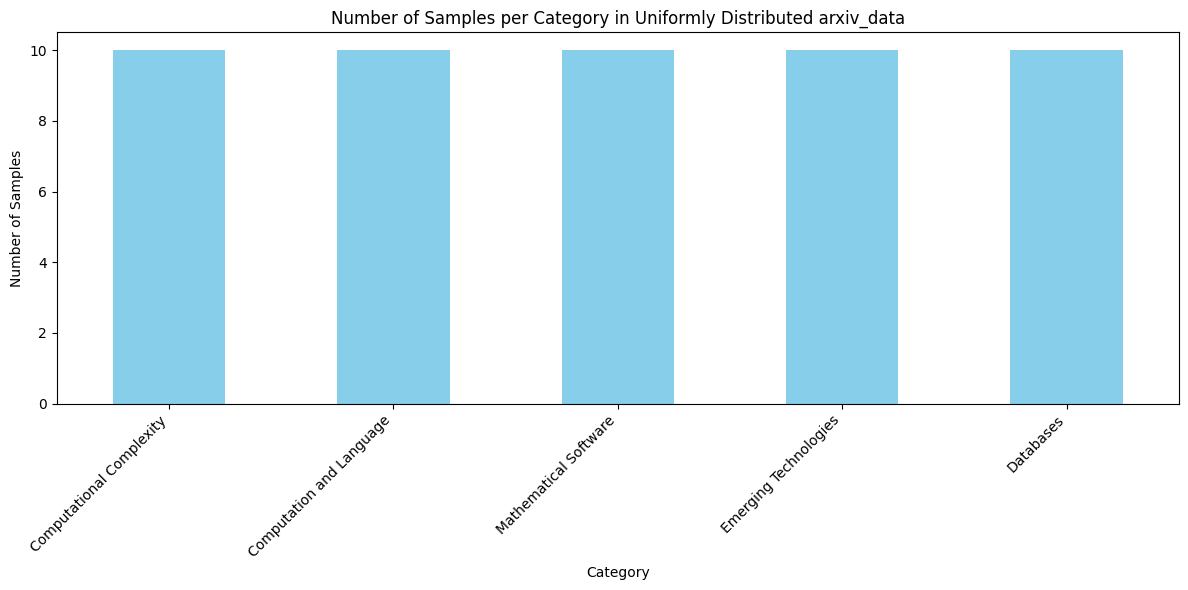

In [13]:
'''
Since it takes EVEN LONGER to do with 'Abstract' so downsampling further
'''

import pandas as pd
import matplotlib.pyplot as plt
import random


arxiv_data_original = pd.read_csv('q2-arxiv-metadata-oai-snapshot-small.csv', index_col=0)
grouped = arxiv_data_original.groupby('first_category_english')

# Randomly select 5 categories
random_categories = random.sample(list(grouped.groups.keys()), 5)
sampled_data = []

#Target number of samples per category
target_samples = 50 // len(random_categories)
# Iterate through each selected category and sample uniformly
for category in random_categories:
    group = grouped.get_group(category)
    if len(group) >= target_samples:
        samples = group.sample(n=target_samples, replace=True)
    else:
        samples = group.sample(n=target_samples, replace=True)
    sampled_data.append(samples)


arxiv_data = pd.concat(sampled_data)
arxiv_data = arxiv_data.sample(frac=1).reset_index(drop=True)

category_counts_uniform = arxiv_data['first_category_english'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(12, 6))
category_counts_uniform.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Category in Uniformly Distributed arxiv_data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

arxiv_candidate_labels = arxiv_data.first_category_english.unique()

In [14]:
# Model 1
from transformers import pipeline

pipe = pipeline(model="facebook/bart-large-mnli")

In [15]:
# Using "Abstract"
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING ABSTRACT +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['first_category_english']
    print("true_label:", true_label)
    result = pipe(f"{row['abstract']}", candidate_labels=arxiv_candidate_labels)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Evaluate
accuracy = accuracy_score(true, predicted)
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: facebook/bart-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING ABSTRACT +++++++++++++++++++++++
==================Iteration:1==================
true_label: Computational Complexity
predicted_label: Computational Complexity
==================Iteration:2==================
true_label: Computational Complexity
predicted_label: Computation and Language
==================Iteration:3==================
true_label: Computational Complexity
predicted_label: Computational Complexity
==================Iteration:4==================
true_label: Computational Complexity
predicted_label: Computational Complexity
==================Iteration:5==================
true_label: Computation and Language
predicted_label: Computational Complexity
==================Iteration:6==================
true_label: Mathematical Software
predicted_label: Mathematical Software
==================Iteration:7==================
true_label: Emerging Technologies
predicted_label: Computational Complexity
==================Iteration:8==================
true_labe

In [16]:
# MODEL2
pipe = pipeline("zero-shot-classification", model="roberta-large-mnli")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Using "Abstract"
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING ABSTRACT +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['first_category_english']
    print("true_label:", true_label)
    result = pipe(f"{row['abstract']}", candidate_labels=arxiv_candidate_labels)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Evaluate
accuracy = accuracy_score(true, predicted)
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: roberta-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING ABSTRACT +++++++++++++++++++++++
==================Iteration:1==================
true_label: Computational Complexity
predicted_label: Computational Complexity
==================Iteration:2==================
true_label: Computational Complexity
predicted_label: Emerging Technologies
==================Iteration:3==================
true_label: Computational Complexity
predicted_label: Computational Complexity
==================Iteration:4==================
true_label: Computational Complexity
predicted_label: Databases
==================Iteration:5==================
true_label: Computation and Language
predicted_label: Emerging Technologies
==================Iteration:6==================
true_label: Mathematical Software
predicted_label: Computational Complexity
==================Iteration:7==================
true_label: Emerging Technologies
predicted_label: Computational Complexity
==================Iteration:8==================
true_label: Emerging Techno

In [18]:
# MODEL 3
from transformers import pipeline
# pipe = pipeline(model="NDugar/v2xl-again-mnli")
pipe = pipeline(model='MoritzLaurer/xtremedistil-l6-h256-mnli-fever-anli-ling-binary')

In [19]:
# Using "Abstract"
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING ABSTRACT +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['first_category_english']
    print("true_label:", true_label)
    result = pipe(f"{row['abstract']}", candidate_labels=arxiv_candidate_labels)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

accuracy = accuracy_score(true, predicted)
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: MoritzLaurer/xtremedistil-l6-h256-mnli-fever-anli-ling-binary ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING ABSTRACT +++++++++++++++++++++++
==================Iteration:1==================
true_label: Computational Complexity
predicted_label: Computation and Language
==================Iteration:2==================
true_label: Computational Complexity
predicted_label: Emerging Technologies
==================Iteration:3==================
true_label: Computational Complexity
predicted_label: Computation and Language
==================Iteration:4==================
true_label: Computational Complexity
predicted_label: Mathematical Software
==================Iteration:5==================
true_label: Computation and Language
predicted_label: Databases
==================Iteration:6==================
true_label: Mathematical Software
predicted_label: Mathematical Software
==================Iteration:7==================
true_label: Emerging Technologies
predicted_label: Computational Complexity
==================Iteration:8==================
true_label: Emerging Technolog

### Comment on your results.

As discussed in the previous response, using the abstract which contains more contextual cues than simple title, all models performed better.

### e) Change labels to long descriptions

In [28]:
category_dict = {
    'Human-Computer Interaction': "Covers human factors, user interfaces, and collaborative computing. Roughly includes material in ACM Subject Classes H.1.2 and all of H.5, except for H.5.1, which is more likely to have Multimedia as the primary subject area.",
    'Computation and Language': "Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area.",
    'Information Theory': "Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.",
    'Other Computer Science': "This is the classification to use for documents that do not fit anywhere else.",
    'Data Structures and Algorithms': "Covers data structures and analysis of algorithms. Roughly includes material in ACM Subject Classes E.1, E.2, F.2.1, and F.2.2.",
    'Discrete Mathematics': "Covers combinatorics, graph theory, applications of probability. Roughly includes material in ACM Subject Classes G.2 and G.3.",
    'Computational Complexity': "Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.",
    'Computer Science and Game Theory': "Covers all theoretical and applied aspects at the intersection of computer science and game theory, including work in mechanism design, learning in games (which may overlap with Learning), foundations of agent modeling in games (which may overlap with Multiagent systems), coordination, specification and formal methods for non-cooperative computational environments. The area also deals with applications of game theory to areas such as electronic commerce.",
    'Symbolic Computation': "Roughly includes material in ACM Subject Class I.1.",
    'Numerical Analysis': "Numerical algorithms for problems in analysis and algebra, scientific computation. cs.NA is an alias for math.NA. Roughly includes material in ACM Subject Class G.1.",
    'Artificial Intelligence': "Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11.",
    'Databases': "Covers database management, datamining, and data processing. Roughly includes material in ACM Subject Classes E.2, E.5, H.0, H.2, and J.1.",
    'Programming Languages': "Covers programming language semantics, language features, programming approaches (such as object-oriented programming, functional programming, logic programming). Also includes material on compilers oriented towards programming languages; other material on compilers may be more appropriate in Architecture (AR). Roughly includes material in ACM Subject Classes D.1 and D.3.",
    'Robotics': "Roughly includes material in ACM Subject Class I.2.9.",
    'Social and Information Networks': "Covers the design, analysis, and modeling of social and information networks, including their applications for on-line information access, communication, and interaction, and their roles as datasets in the exploration of questions in these and other domains, including connections to the social and biological sciences. Analysis and modeling of such networks includes topics in ACM Subject classes F.2, G.2, G.3, H.2, and I.2; applications in computing include topics in H.3, H.4, and H.5; and applications at the interface of computing and other disciplines include topics in J.1--J.7. Papers on computer communication systems and network protocols (e.g. TCP/IP) are generally a closer fit to the Networking and Internet Architecture (cs.NI) category.",
    'Computer Vision and Pattern Recognition': "Covers image processing, computer vision, pattern recognition, and scene understanding. Roughly includes material in ACM Subject Classes I.2.10, I.4, and I.5.",
    'Cryptography and Security': "Covers all areas of cryptography and security including authentication, public key cryptosytems, proof-carrying code, etc. Roughly includes material in ACM Subject Classes D.4.6 and E.3.",
    'Machine Learning': "Papers on all aspects of machine learning research (supervised, unsupervised, reinforcement learning, bandit problems, and so on) including also robustness, explanation, fairness, and methodology. cs.LG is also an appropriate primary category for applications of machine learning methods.",
    'Information Retrieval': "Covers indexing, dictionaries, retrieval, content and analysis. Roughly includes material in ACM Subject Classes H.3.0, H.3.1, H.3.2, H.3.3, and H.3.4.",
    'Neural and Evolutionary Computing': "Covers neural networks, connectionism, genetic algorithms, artificial life, adaptive behavior. Roughly includes some material in ACM Subject Class C.1.3, I.2.6, I.5.",
    'Formal Languages and Automata Theory': "Covers automata theory, formal language theory, grammars, and combinatorics on words. This roughly corresponds to ACM Subject Classes F.1.1, and F.4.3. Papers dealing with computational complexity should go to cs.CC; papers dealing with logic should go to cs.LO.",
    'Distributed, Parallel, and Cluster Computing': "Covers fault-tolerance, distributed algorithms, stabilility, parallel computation, and cluster computing. Roughly includes material in ACM Subject Classes C.1.2, C.1.4, C.2.4, D.1.3, D.4.5, D.4.7, E.1.",
    'Software Engineering': "Covers design tools, software metrics, testing and debugging, programming environments, etc. Roughly includes material in all of ACM Subject Classes D.2, except that D.2.4 (program verification) should probably have Logics in Computer Science as the primary subject area.",
    'Mathematical Software': "Roughly includes material in ACM Subject Class G.4.",
    'Computers and Society': "Covers impact of computers on society, computer ethics, information technology and public policy, legal aspects of computing, computers and education. Roughly includes material in ACM Subject Classes K.0, K.2, K.3, K.4, K.5, and K.7.",
    'Computational Engineering, Finance, and Science': "Covers applications of computer science to the mathematical modeling of complex systems in the fields of science, engineering, and finance. Papers here are interdisciplinary and applications-oriented, focusing on techniques and tools that enable challenging computational simulations to be performed, for which the use of supercomputers or distributed computing platforms is often required. Includes material in ACM Subject Classes J.2, J.3, and J.4 (economics).",
    'Emerging Technologies': "Covers approaches to information processing (computing, communication, sensing) and bio-chemical analysis based on alternatives to silicon CMOS-based technologies, such as nanoscale electronic, photonic, spin-based, superconducting, mechanical, bio-chemical and quantum technologies (this list is not exclusive). Topics of interest include (1) building blocks for emerging technologies, their scalability and adoption in larger systems, including integration with traditional technologies, (2) modeling, design and optimization of novel devices and systems, (3) models of computation, algorithm design and programming for emerging technologies.",
}

In [29]:
'''
The same code as using 'Abstract'
'''
arxiv_data['long_category'] = arxiv_data['first_category_english'].map(category_dict)
arxiv_candidate_labels_long = arxiv_data.long_category.unique()

arxiv_data.head(5)

,title,authors,date,abstract,categories,first_category,first_category_english,long_category
0,Hardness of Approximation of (Multi-)LCS over ...,"Amey Bhangale, Diptarka Chakraborty, Rajendra ...",2020-06-25,The problem of finding longest common subseq...,cs.CC,cs.CC,Computational Complexity,"Covers models of computation, complexity class..."
1,Multiparty Karchmer-Wigderson Games and Thresh...,Alexander Kozachinskiy and Vladimir Podolskii,2020-02-19,We suggest a generalization of Karchmer-Wigd...,cs.CC,cs.CC,Computational Complexity,"Covers models of computation, complexity class..."
2,Parameterized Complexity of Scheduling Chains ...,Hans L. Bodlaender and Marieke van der Wegen,2020-07-20,"In this paper, we consider the parameterized...",cs.CC,cs.CC,Computational Complexity,"Covers models of computation, complexity class..."
3,A generalized Sylvester-Gallai type theorem fo...,Shir Peleg and Amir Shpilka,2020-03-12,In this work we prove a version of the Sylve...,cs.CC cs.CG,cs.CC,Computational Complexity,"Covers models of computation, complexity class..."
4,Enhancing Out-Of-Domain Utterance Detection wi...,"Yueqi Feng, Jiali Lin",2020-03-30,"For most intelligent assistant systems, it i...",cs.CL,cs.CL,Computation and Language,Covers natural language processing. Roughly in...


In [ ]:
print(arxiv_candidate_labels_long)

In [30]:
# Model 1
from transformers import pipeline

pipe = pipeline(model="facebook/bart-large-mnli")

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING LONG LABEL + TITLE +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['long_category']
    print("true_label:", true_label)
    result = pipe(f"{row['title']}", candidate_labels=arxiv_candidate_labels_long)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: facebook/bart-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING LONG LABEL + TITLE +++++++++++++++++++++++
==================Iteration:1==================
true_label: Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.
predicted_label: Covers approaches to information processing (computing, communication, sensing) and bio-chemical analysis based on alternatives to silicon CMOS-based technologies, such as nanoscale electronic, photonic, spin-based, superconducting, mechanical, bio-chemical and quantum technologies (this list is not exclusive). Topics

In [32]:
# MODEL2
pipe = pipeline("zero-shot-classification", model="roberta-large-mnli")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING LONG LABEL + TITLE +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['long_category']
    print("true_label:", true_label)
    result = pipe(f"{row['title']}", candidate_labels=arxiv_candidate_labels_long)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: roberta-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING LONG LABEL + TITLE +++++++++++++++++++++++
==================Iteration:1==================
true_label: Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.
predicted_label: Covers approaches to information processing (computing, communication, sensing) and bio-chemical analysis based on alternatives to silicon CMOS-based technologies, such as nanoscale electronic, photonic, spin-based, superconducting, mechanical, bio-chemical and quantum technologies (this list is not exclusive). Topics

In [34]:
# MODEL 3
from transformers import pipeline
# pipe = pipeline(model="NDugar/v2xl-again-mnli")
pipe = pipeline(model='MoritzLaurer/xtremedistil-l6-h256-mnli-fever-anli-ling-binary')

In [35]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING LONG LABEL + TITLE +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['long_category']
    print("true_label:", true_label)
    result = pipe(f"{row['title']}", candidate_labels=arxiv_candidate_labels_long)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: NDugar/v2xl-again-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING LONG LABEL + TITLE +++++++++++++++++++++++
==================Iteration:1==================
true_label: Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.
predicted_label: Covers approaches to information processing (computing, communication, sensing) and bio-chemical analysis based on alternatives to silicon CMOS-based technologies, such as nanoscale electronic, photonic, spin-based, superconducting, mechanical, bio-chemical and quantum technologies (this list is not exclusive). Topics

### Can the Zero- Shot Text Classification do a better job at classifying the categories using the long descriptions as labels?

No, with the extended labels from the provided website which aren't notably more descriptive, the classification accuracy or F1 scores they did not improve for any of the models. For example, the class 'Mathematical Software' is mapped to a definition like 'Roughly includes material in ACM Subject Class G.4'. This isn't add more contextual cues to the label 'Matehmatical Software' but indeed even masks it. Therefore, it is expected that we observe decrease in performance considering the inadequacy of these extended descriptions in aiding classification.

### Additional attempt, seeing if using 'abstract' instead of 'title' improves the accuracy and F1 score.

In [36]:
# MODEL2
pipe = pipeline("zero-shot-classification", model="roberta-large-mnli")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING LONG LABEL + ABSTRACT +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['long_category']
    print("true_label:", true_label)
    result = pipe(f"{row['abstract']}", candidate_labels=arxiv_candidate_labels_long)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
# Calculate F1 score
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: roberta-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted, zero_division=1)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING LONG LABEL + ABSTRACT +++++++++++++++++++++++
==================Iteration:1==================
true_label: Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.
predicted_label: Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech,

## Another Experiment: Not using Arxiv Label Definition but using more descriptive dictionary definition.

In [105]:
long_category = [
    ('Human-Computer Interaction', 'Study of how people interact with computers and designing interfaces for seamless interaction.'),
    ('Computation and Language', 'Focuses on the intersection of computation and natural language, including computational linguistics and language processing.'),
    ('Information Theory', 'Studies quantification, storage, and communication of information.'),
    ('Other Computer Science', 'A broad category encompassing topics not specifically classified elsewhere in computer science.'),
    ('Data Structures and Algorithms', 'Deals with organizing and storing data efficiently, along with designing algorithms to manipulate this data.'),
    ('Discrete Mathematics', 'Branch of mathematics dealing with discrete structures and mathematical reasoning.'),
    ('Computational Complexity', 'Analyzes the computational resources needed to solve computational problems.'),
    ('Computer Science and Game Theory', 'Explores the interplay between computer science and game theory, particularly in decision-making and strategy.'),
    ('Symbolic Computation', 'Focuses on algorithms and systems for symbolic manipulation in mathematics.'),
    ('Numerical Analysis', 'Uses numerical approximation and algorithms for mathematical problems.'),
    ('Artificial Intelligence', 'Studies the development of intelligent machines capable of simulating human intelligence.'),
    ('Databases', 'Deals with designing, creating, and managing databases to store and retrieve data efficiently.'),
    ('Programming Languages', 'Explores the design and implementation of programming languages.'),
    ('Robotics', 'Focuses on designing, constructing, and programming robots to perform tasks autonomously or semi-autonomously.'),
    ('Social and Information Networks', 'Studies the structure and dynamics of social networks and information flow within them.'),
    ('Computer Vision and Pattern Recognition', 'Concerned with enabling computers to interpret visual information and recognize patterns.'),
    ('Cryptography and Security', 'Involves securing communication and data through encryption and safeguarding against unauthorized access.'),
    ('Machine Learning', 'Focuses on developing algorithms that enable computers to learn from data and make predictions or decisions.'),
    ('Information Retrieval', 'Deals with the retrieval of information from large collections of data, typically in databases or on the internet.'),
    ('Neural and Evolutionary Computing', 'Studies models and algorithms inspired by neural networks and evolutionary processes.'),
    ('Formal Languages and Automata Theory', 'Studies abstract machines and formal languages, foundational in computer science theory.'),
    ('Distributed, Parallel, and Cluster Computing', 'Concerned with distributed systems, parallel processing, and clusters to solve large-scale computational problems.'),
    ('Software Engineering', 'Focuses on the systematic design, development, maintenance, and testing of software.'),
    ('Mathematical Software', 'Development and use of software for mathematical computation and analysis.'),
    ('Computers and Society', 'Examines the impact of computing on society, considering ethical, social, and legal aspects.'),
    ('Computational Engineering, Finance, and Science', 'Application of computational methods in engineering, finance, and scientific research.'),
    ('Emerging Technologies', 'Investigates new and cutting-edge technologies that are in the process of development or adoption.')
]

category_dict = {category: definition for category, definition in long_category}

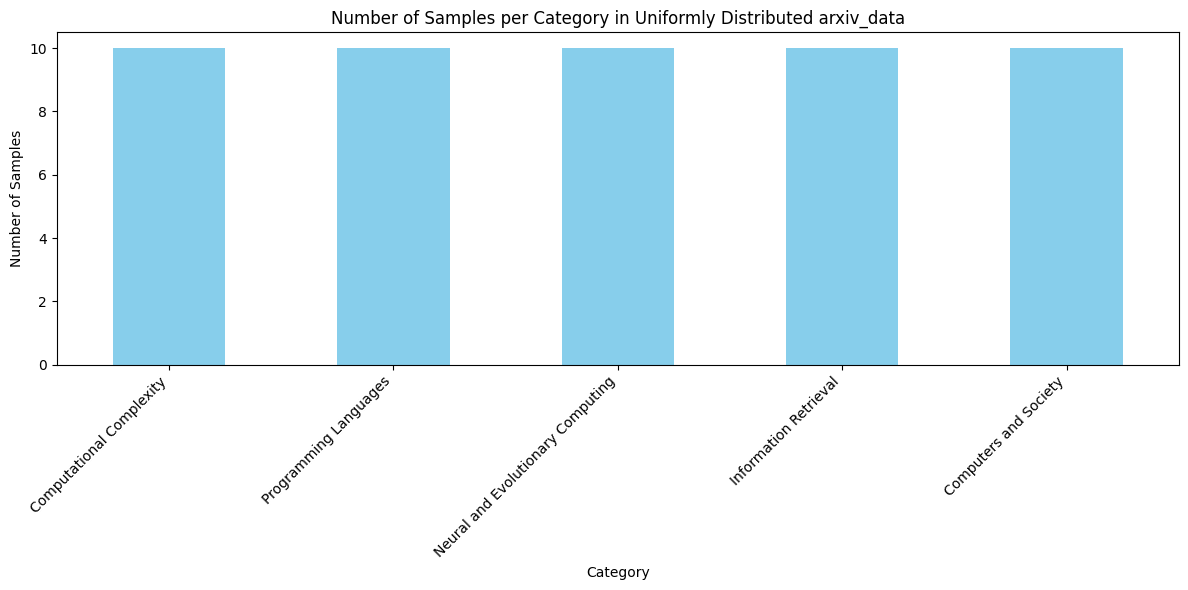

In [106]:
'''
Since it takes EVEN LONGER to do with 'Abstract' so downsampling further
'''

import pandas as pd
import matplotlib.pyplot as plt
import random


arxiv_data_original = pd.read_csv('q2-arxiv-metadata-oai-snapshot-small.csv', index_col=0)
grouped = arxiv_data_original.groupby('first_category_english')

# Randomly select 5 categories
random_categories = random.sample(list(grouped.groups.keys()), 5)
sampled_data = []

#Target number of samples per category
target_samples = 50 // len(random_categories)
# Iterate through each selected category and sample uniformly
for category in random_categories:
    group = grouped.get_group(category)
    if len(group) >= target_samples:
        samples = group.sample(n=target_samples, replace=True)
    else:
        samples = group.sample(n=target_samples, replace=True)
    sampled_data.append(samples)


arxiv_data = pd.concat(sampled_data)
arxiv_data = arxiv_data.sample(frac=1).reset_index(drop=True)

category_counts_uniform = arxiv_data['first_category_english'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(12, 6))
category_counts_uniform.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Category in Uniformly Distributed arxiv_data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

arxiv_candidate_labels = arxiv_data.first_category_english.unique()

In [107]:
arxiv_data['long_category'] = arxiv_data['first_category_english'].map(category_dict)
arxiv_candidate_labels_long = arxiv_data.long_category.unique()

arxiv_data.head(5)

,title,authors,date,abstract,categories,first_category,first_category_english,long_category
0,Hyperbolic Minesweeper is in P,Eryk Kopczy\'nski,2020-02-25,"We show that, while Minesweeper is NP-comple...",cs.CC cs.AI,cs.CC,Computational Complexity,Analyzes the computational resources needed to...
1,Modeling Black-Box Components with Probabilist...,"Bruce Collie, Jackson Woodruff, Michael F.P. O...",2020-10-13,This paper is concerned with synthesizing pr...,cs.PL,cs.PL,Programming Languages,Explores the design and implementation of prog...
2,Distributed Evolution of Deep Autoencoders,"Jeff Hajewski, Suely Oliveira, and Xiaoyu Xing",2020-04-17,Autoencoders have seen wide success in domai...,cs.NE,cs.NE,Neural and Evolutionary Computing,Studies models and algorithms inspired by neur...
3,Partial complementation of graphs,"Fedor V. Fomin, Petr A. Golovach, Torstein J. ...",2020-06-11,A partial complement of the graph $G$ is a g...,cs.CC cs.DM,cs.CC,Computational Complexity,Analyzes the computational resources needed to...
4,RustHorn: CHC-based Verification for Rust Prog...,Yusuke Matsushita and Takeshi Tsukada and Naok...,2020-06-12,Reduction to the satisfiability problem for ...,cs.PL,cs.PL,Programming Languages,Explores the design and implementation of prog...


In [108]:
# MODEL2
pipe = pipeline("zero-shot-classification", model="roberta-large-mnli")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("+++++++++++++++++++++++ USING LONG LABEL + ABSTRACT +++++++++++++++++++++++")
i = 1
true = []
predicted = []
for index, row in arxiv_data.iterrows():
    print(f"==================Iteration:{i}==================")
    true_label = row['long_category']
    print("true_label:", true_label)
    result = pipe(f"{row['abstract']}", candidate_labels=arxiv_candidate_labels_long)
    predicted_label = result['labels'][result['scores'].index(max(result['scores']))]
    print("predicted_label:", predicted_label)
    true.append(true_label)
    predicted.append(predicted_label)
    i += 1

# Evaluate
accuracy = accuracy_score(true, predicted)
f1_weighted = f1_score(true, predicted, average='weighted', zero_division=1)

print("========== Model: roberta-large-mnli ==========")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Weighted): {f1_weighted}")

# Generate classification report
class_report = classification_report(true, predicted)
print("========== Classification Report ==========")
print(class_report)

+++++++++++++++++++++++ USING LONG LABEL + ABSTRACT +++++++++++++++++++++++
==================Iteration:1==================
true_label: Analyzes the computational resources needed to solve computational problems.
predicted_label: Examines the impact of computing on society, considering ethical, social, and legal aspects.
==================Iteration:2==================
true_label: Explores the design and implementation of programming languages.
predicted_label: Explores the design and implementation of programming languages.
==================Iteration:3==================
true_label: Studies models and algorithms inspired by neural networks and evolutionary processes.
predicted_label: Studies models and algorithms inspired by neural networks and evolutionary processes.
==================Iteration:4==================
true_label: Analyzes the computational resources needed to solve computational problems.
predicted_label: Analyzes the computational resources needed to solve computational 

### Analysis:

Using actually descriptive longer label, it did perform better than when it had a simple (condensed) label. Indeed, this combination of the expressive label and abstract had the highest accuracy and F1 score. This shows the importance of providing quality context que to the model for it to perform well.